# Spam or Ham
Lab Assignment Two: Exploring Text Data

**_Jake Oien, Seung Ki Lee, Jenn Le_**

## Business Understanding

This dataset contains raw text messages that were classified as either spam or ham, as in not spam. Collecting and analyzing this data can be useful for identifying the characteristics of spam messages and in turn, assist in filtering out spam in text messages as well as emails. Individuals and groups are being more frequently targeting consumers through their text messages as the medium is more personal than email and this can cause people to lower their guards. Being able to recognize the patterns prevalent in a spam message can help avoid possibly harmful situations that can be caused by these spam messages.

The texts that make up this dataset come from free sources on the internet, including 425 messages from the Grumbletext Web Site, 3,375 from the NUS SMS Corpus (NSC), 450 from Caroline Tag's PhD Thesis, and 1,325 from the SMS Spam Corpus v.0.1 Big.

While responding to spam messages can be harmful, so can not responding to important messages. As such, for a prediction algorithm to be useful, it has to correctly classify messages as "ham" 100% of the time. False positives, however, are acceptable since people can still judge for themselves whether a text is spam or not. 

Dataset Source: https://archive.ics.uci.edu/ml/datasets/sms+spam+collection

## Data Encoding

### Read in Data as string

In [76]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Here, we'll import the data, remove unwanted columns(cause this data has 3 empty columns for some reason,
# and rename the columns to be more descriptive
data = pd.read_csv("./spam.csv", encoding='latin-1')
data = data.drop(["Unnamed: 2", "Unnamed: 3", "Unnamed: 4"], axis=1)
data = data.rename(columns={"v1":"label", "v2":"text"})

data.head()

,label,text
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [52]:
import warnings

#for testing
TEST = False

warnings.filterwarnings("ignore")
%matplotlib inline

if TEST:
    print (data)

### Verify Data Quality

To clean up the data set, we've analyzed what words were meaningless in the context of constituting a message. First major filler we've noticed was the markdown tags. We concluded words such as **& lt;#& gt;** are used for formatting purposes and not for anything pertinent to the meaning of the text. Also, we did not come across any words which started with '&' and ended with ';' which wasn't a markdown tag, so the probability of removing important data seems very low. Aside from this, generally accepted stopwords embeded in the sklearn were removed as they work to give context but not meaning.

In [53]:
#verify data quality
import re

#remove irrelavant words : markdown tags
data.text.replace(to_replace=["#?\&(lt|gt)\;"],value=[''],regex=True, inplace=True)  # get rid of &lt; type encodings
if TEST:
    print (data)


We should add a column which stores the length of a text, which will be useful later. 

In [54]:
length = lambda x: len(x)
data["text_length"] = data["text"].map(length)  # add a column indicating how long a message is
data.head(10)

,label,text,text_length
0,ham,"Go until jurong point, crazy.. Available only ...",111
1,ham,Ok lar... Joking wif u oni...,29
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,155
3,ham,U dun say so early hor... U c already then say...,49
4,ham,"Nah I don't think he goes to usf, he lives aro...",61
5,spam,FreeMsg Hey there darling it's been 3 week's n...,148
6,ham,Even my brother is not like to speak with me. ...,77
7,ham,As per your request 'Melle Melle (Oru Minnamin...,160
8,spam,WINNER!! As a valued network customer you have...,158
9,spam,Had your mobile 11 months or more? U R entitle...,154


### Convert the Data into a Sparse Encoded Bag-of-Words Representation

In [55]:
from sklearn.feature_extraction.text import CountVectorizer
#create bag of words
count_vector = CountVectorizer(stop_words='english')
bag_of_words = count_vector.fit_transform(data['text'])

#put word counts in pd.DataFrame
bag_of_words_df = pd.DataFrame(data=bag_of_words.toarray(), columns=count_vector.get_feature_names())

bag_of_words_df.sum().sort_values()[-10:]

come    229
got     239
like    245
good    245
know    261
ll      269
free    284
ok      292
just    371
ur      385
dtype: int64

Some of the top 10 word in the dataset are typical "responses" in a casual texting environment such as "ok," or "good." words represent the texter's state such as "free," "come," "know" were also included.

Top occurence was "ur," a shorthand term for "your" or "you are."

On the other hand, we also observed terms with flexible and various usage in high frequency. Causative verb of "got," and "like," the new comma, and adverb "just."

### Convert Data into Sparse Encoded TF-IDF Representation

In [56]:
from sklearn.feature_extraction.text import TfidfVectorizer

#Create tfidf
tfidf_vector = TfidfVectorizer(stop_words='english')
tfidf_matrix = tfidf_vector.fit_transform(data['text'])

#build pd.DataFrame
tfidf_df = pd.DataFrame(data=tfidf_matrix.toarray(), columns=tfidf_vector.get_feature_names())

#tfidf_df.head(n=10)
tfidf_df.sum().sort_values()[-10:]

like      56.066259
sorry     56.415806
time      56.746412
know      59.171328
good      60.091039
ur        64.191167
come      66.620830
just      72.088102
ll        80.197967
ok       103.056455
dtype: float64

Using TF-IDF representation, the pool of top words changed. "Sorry" replaced "Free" in the listing. in relative placements of the value, ok marked up at highest value instead of ur. ur actually only came up around middle of the top 10 list.

In [57]:
import matplotlib.pyplot as plt
import warnings
warnings.simplefilter('ignore', DeprecationWarning)
%matplotlib inline 

Now let's remove duplicate texts from the dataset. Duplicate data would only serve to muddy up the data, as the same text classified the same way would not provide new information. 

In [58]:
# data[data.label == "spam"].text.values[0:7]
len_data = len(data)
data.drop_duplicates(inplace=True)
len_data_no_dupes = len(data)

print("Number of total text messages: {}".format(len_data))
print("Number of unique text messages: {}".format(len_data_no_dupes))
print("Number of duplicates removed: {}".format(len_data - len_data_no_dupes))

Number of total text messages: 5572
Number of unique text messages: 5169
Number of duplicates removed: 403


We see that we removed 403 duplicate messages from the dataset. 

## Data Visualization

First, let's take a look at how long the messages are.

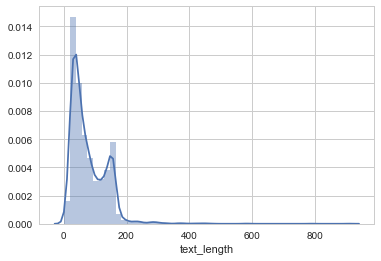

In [59]:
import seaborn as sns
sns.set_style("whitegrid")
cmap = sns.diverging_palette(220, 10, as_cmap=True) # one of the many color mappings

sns.distplot(data.text_length)

The vast majority of the messages are less than 200 characters long, and the tail is getting in the way of visualizing the bulk of the data. Let's take a closer look at the bulk of the data, so we'll trim some of that tail off. 

In [60]:
cutoff = 225
num_entries_in_tail = data[data.text_length > cutoff].count()["text_length"]
print("Num entries longer than {} characters long: {}".format(cutoff, num_entries_in_tail))
print("Number of texts in dataset: {}".format(len(data)))
print("Percentage of total data being trimmed from the top end: {}%".format(round(num_entries_in_tail/len(data)*100, 3)))

Num entries longer than 225 characters long: 76
Number of texts in dataset: 5169
Percentage of total data being trimmed from the top end: 1.47%


We will use 225 as the cutoff for messages, so that we still keep some of the tail. We see that 78 of the messages are longer than 225 characters. In order to get a better picture of the bulk of the data, we trim those from data when graphing.

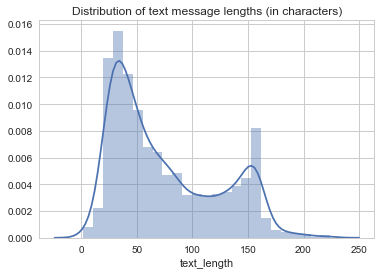

In [61]:
data_trimmed = data[data.text_length <= 225]
data_trimmed.reset_index(drop=True, inplace=True)  # we do this to make the indexes go from (0, len(data_trimmed), 
                                     # rather than (0,len(data))
sns.distplot(data_trimmed.text_length)
plt.title("Distribution of text message lengths (in characters)");

We see that there is a bimodal distribution of text messages, with the larger part of them being short messages. However, this could be because there are many more ham messages than spam messages. Let's see how much of the dataset is spam and how much is ham. 

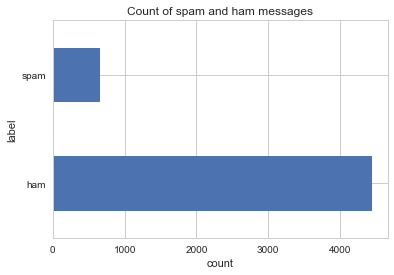

In [62]:
data_grouped = data_trimmed.groupby(by="label")  # separate ham and spam
# sns.barplot(x="label", y="count", data=data_grouped.text)
count = data_grouped.text.count()  # just the count of all entries
ax = count.plot(kind="barh")
plt.xlabel("count")
plt.title("Count of spam and ham messages");


We can see that there are many more ham messages than spam messages. So, ham likely skews the distribution one way or another. Let's take a look at the percent distributions split by ham/spam.

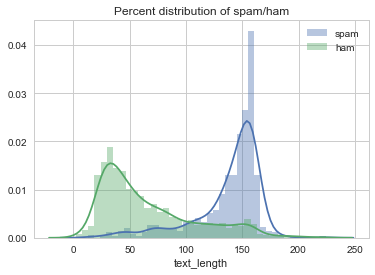

In [63]:
fig, ax = plt.subplots()

sns.distplot(data_trimmed[data_trimmed.label == "spam"].text_length, label="spam", ax=ax, bins=40)
sns.distplot(data_trimmed[data_trimmed.label == "ham"].text_length, label="ham", ax=ax, bins=40)

plt.title("Percent distribution of spam/ham")
plt.legend();

We can see that there appears to be a noticable difference in the distributions. The ham distribution is skewed towards shorter messages while the spam distribution is skewed towards longer messages. This would provide a great feature for use in a machine learning algorithm. 

We also see that there is a sharp drop off of both types messages after the 160-character mark, with spam messages taking a nose dive. This could be explained by SMS's character limit. After 160 characters, a message must be split into multiple parts. So, both "hammers" and "spammers" might try to avoid hitting that limit which might explain the drop.

106

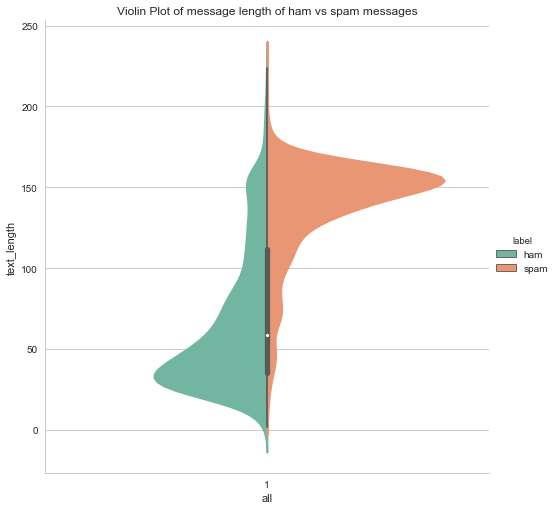

In [87]:
## This code displays a violin plot, and should probably be deleted if it's not gonna be used ###

# do this to stop pandas from yelling at us about acting on a copy
pd.options.mode.chained_assignment = None  # default='warn'  

# set a column to split the violin on
data_trimmed["all"] = data_trimmed.text.map(lambda x: 1)

sns.factorplot(x="all",y='text_length',hue='label',data=data_trimmed, 
               kind='violin', # other options: violin, bar, box, and others 
               palette='Set2', size=7,ci=95, split=True)
plt.title("Violin Plot of message length of ham vs spam messages");

# adapted from "03. DataVisualization.ipynb" in "Simplifying with Seaborn" by Eric Larson
len(data_trimmed.ix[51].text)

The data is distinct, but closer to the intersection of the graphs and where the difference between the two distributions is smaller, the length becomes worse at classifying the data. So, we should look at other means that might separate the data out. One separator of the data might be the number of words in a text message. Let's redo the bag of words, but leave in everything. 

In [65]:
from sklearn.feature_extraction.text import CountVectorizer
pd.options.display.max_columns = 100

#create bag of words
count_vector_trimmed = CountVectorizer(stop_words=None)
trimmed_bag_of_words = count_vector_trimmed.fit_transform(data_trimmed['text'])

#put word counts in pd.DataFrame
trimmed_bag_of_words_df = pd.DataFrame(data=trimmed_bag_of_words.toarray(), 
                                       columns=count_vector_trimmed.get_feature_names())

trimmed_bag_of_words_df.head()

,00,000,000pes,008704050406,0089,0121,01223585236,01223585334,0125698789,02,0207,02072069400,02073162414,02085076972,021,03,04,0430,05,050703,0578,06,07,07008009200,07046744435,07090201529,07090298926,07099833605,07123456789,0721072,07732584351,07734396839,07742676969,07753741225,0776xxxxxxx,07781482378,07786200117,077xxx,078,07801543489,07808,07808247860,07808726822,07815296484,07821230901,078498,07880867867,0789xxxxxxx,07946746291,0796xxxxxx,...,youuuuu,youwanna,youåõre,yoville,yowifes,yoyyooo,yr,yrs,ystrday,ything,yummmm,yummy,yun,yunny,yuo,yuou,yup,yupz,zac,zaher,zebra,zed,zeros,zhong,zindgi,zoe,zogtorius,zoom,zouk,zyada,åè10,åð,åòharry,åòit,åômorrow,åôrents,ì_,ì¼1,ìä,ìï,ó_,û_,û_thanks,ûªm,ûªt,ûªve,ûï,ûïharry,ûò,ûówell
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


First, we see a lot of strange characters. We don't know what these characters are, but they likely come from an encoding mismatch. Without that knowledge, we will leave them in for now, until we can understand better what the characters mean. 

Now let's add a component to the data to count the number of words in a text. 

In [66]:
print(count_vector_trimmed.inverse_transform(trimmed_bag_of_words_df.ix[2]))

print(data_trimmed.ix[2].text)

[array(['08452810075over18', '2005', '21st', '87121', 'apply', 'comp',
       'cup', 'entry', 'fa', 'final', 'free', 'in', 'may', 'question',
       'rate', 'receive', 'std', 'text', 'tkts', 'to', 'txt', 'win', 'wkly'], 
      dtype='<U34')]
Free entry in 2 a wkly comp to win FA Cup final tkts 21st May 2005. Text FA to 87121 to receive entry question(std txt rate)T&C's apply 08452810075over18's


In [67]:
arr = trimmed_bag_of_words_df.T.sum()  # this creates a column of the sum of all words in a text
data_trimmed["num_words"] = arr
data_trimmed.head()

,label,text,text_length,num_words
0,ham,"Go until jurong point, crazy.. Available only ...",111,18
1,ham,Ok lar... Joking wif u oni...,29,5
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,155,27
3,ham,U dun say so early hor... U c already then say...,49,8
4,ham,"Nah I don't think he goes to usf, he lives aro...",61,12


Now let's graph the texts by number of words. 

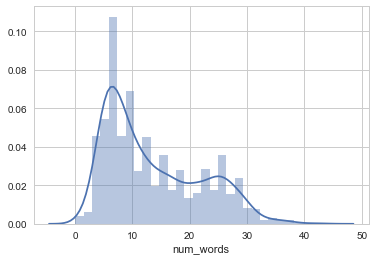

In [68]:
sns.distplot(data_trimmed.num_words)

Again we see a similar bimodal distribution. This makes sense, because longer texts should be made of more words, so that it follows a similar distribution makes sense. Maybe we should look at the average number of characters per word? 

In [69]:
data_trimmed["avg_chars_per_word"] = data_trimmed.text_length/data_trimmed.num_words
data_trimmed.head(10)

,label,text,text_length,num_words,avg_chars_per_word
0,ham,"Go until jurong point, crazy.. Available only ...",111,18,6.166667
1,ham,Ok lar... Joking wif u oni...,29,5,5.800000
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,155,27,5.740741
3,ham,U dun say so early hor... U c already then say...,49,8,6.125000
4,ham,"Nah I don't think he goes to usf, he lives aro...",61,12,5.083333
5,spam,FreeMsg Hey there darling it's been 3 week's n...,148,30,4.933333
6,ham,Even my brother is not like to speak with me. ...,77,16,4.812500
7,ham,As per your request 'Melle Melle (Oru Minnamin...,160,25,6.400000
8,spam,WINNER!! As a valued network customer you have...,158,25,6.320000
9,spam,Had your mobile 11 months or more? U R entitle...,154,27,5.703704


A note: This is not exactly the average of the lengths of words. It is a measure for the average number of characters needed to convey a word in a given message. This includes spaces, for example, and characters like "(" which are considered to separate words.  Anyway, let's see what it looks like. 

OverflowError: cannot convert float infinity to integer

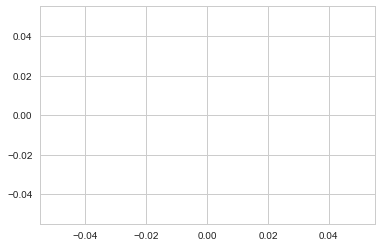

In [70]:
sns.distplot(data_trimmed.avg_chars_per_word)

Huh? What happened here? Some values are infinite. Let's look. 

In [84]:
data_trimmed[data_trimmed.avg_chars_per_word > 20]

,label,text,text_length,num_words,avg_chars_per_word
3146,ham,:),3,0,inf
3962,ham,G.W.R,5,0,inf
4434,ham,:-) :-),7,0,inf
4531,ham,K..k.:)congratulation ..,24,1,24.000000
4748,ham,U 2.,4,0,inf


Smiley faces aren't words, huh? They'll have their day. For now, we'll exclude those 4 records in future graphs. 

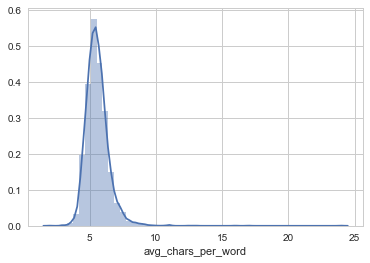

In [85]:
data_trimmed = data_trimmed[data_trimmed.avg_chars_per_word < 50]
data_trimmed.reset_index(inplace=True, drop=True)  # need to remember to do this
sns.distplot(data_trimmed.avg_chars_per_word)

Zoom, enhance!

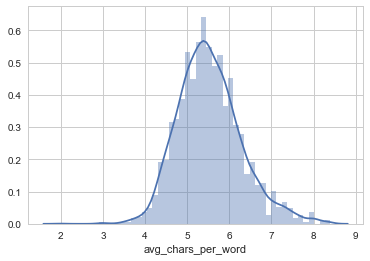

In [86]:
sns.distplot(data_trimmed.avg_chars_per_word[data_trimmed.avg_chars_per_word < 8.5])

We can see that the distribution is fairly symmetrical, with what looks like a slight skew towards less characters per word. This could be looked at for spam vs. ham. 

In [ ]:
## TODO: 
## Look at the vocabulary size of spam messages vs non spam messages
## Graph tfidf values of the most relevant words
## Number of capital letters
## Number of words not in some vocabulary, maybe look at you vs. u
## 200 vs. two hundred?
## Presence of special characters
## How often words go together
## Heatmap association
## Look at the words in the close together length

### Target Class Visualization

Let's now take a look at the characteristics of spam and ham messages separately. First, we'll separate the two labels into their own data frames.

In [74]:
spam = data[data.label == "spam"]
ham = data[data.label =="ham"]

spam.head()

,label,text,text_length
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,155
5,spam,FreeMsg Hey there darling it's been 3 week's n...,148
8,spam,WINNER!! As a valued network customer you have...,158
9,spam,Had your mobile 11 months or more? U R entitle...,154
11,spam,"SIX chances to win CASH! From 100 to 20,000 po...",136


In [75]:
ham.head()

,label,text,text_length
0,ham,"Go until jurong point, crazy.. Available only ...",111
1,ham,Ok lar... Joking wif u oni...,29
3,ham,U dun say so early hor... U c already then say...,49
4,ham,"Nah I don't think he goes to usf, he lives aro...",61
6,ham,Even my brother is not like to speak with me. ...,77


To analyze the most common relevant words and their frequencies in each of these classes, we'll create a few visualizations based on the tfidf rankings. Earlier, we got the tfidf from the entire dataset but for this, it'd be better if we created separate rankings for each class.

In [102]:
#Create tfidf
tfidf_vector_spam = TfidfVectorizer(stop_words='english')
tfidf_matrix_spam = tfidf_vector_spam.fit_transform(spam['text'])

#build pd.DataFrame
tfidf_df_spam = pd.DataFrame(data=tfidf_matrix_spam.toarray(), columns=tfidf_vector_spam.get_feature_names())

#tfidf_df.head(n=10)
tfidf_df_spam.sum().sort_values()[-10:]

www       11.614956
prize     14.194976
reply     14.304646
stop      14.485272
claim     14.501724
text      15.118098
ur        15.153359
txt       15.503044
mobile    15.836625
free      23.237880
dtype: float64

We'll now count the number of times the top 10 words have been used in the spam messages as well as the ham ones. Using code to get those words is a pain so we're just gonna make a list.

In [103]:
relevant_words_spam = ["www", "prize", "reply", "stop", "claim", "text", "ur", "txt", "mobile", "free"]

In [115]:
count_vector = CountVectorizer(stop_words='english')
bag_of_words = count_vector.fit_transform(data['text'])

#put word counts in pd.DataFrame
bag_of_words_df = pd.DataFrame(data=bag_of_words.toarray(), columns=count_vector.get_feature_names())

bag_of_words_df.sum().sort_values()[-10:]

good    245
like    245
know    261
ll      269
free    284
ok      292
lt      316
gt      318
just    371
ur      385
dtype: int64

In [116]:
bag_of_words_df = bag_of_words_df[relevant_words_spam]
bag_of_words_df.sum().sort_values()

prize      93
www       100
claim     113
mobile    142
reply     148
stop      158
txt       177
text      193
free      284
ur        385
dtype: int64

Here, we can see that only the words "ur" and "free" make it into the top 10 of both lists. Other words that have a high count but low tfidf such as "ok" or "know" are words that frequently make their way into casual conversation. However, words that have a high tfidf such as "claim" or "prize" do not.

In [117]:
#Create tfidf
tfidf_vector_ham = TfidfVectorizer(stop_words='english')
tfidf_matrix_ham = tfidf_vector_ham.fit_transform(ham['text'])

#build pd.DataFrame
tfidf_df_ham = pd.DataFrame(data=tfidf_matrix_ham.toarray(), columns=tfidf_vector_ham.get_feature_names())

#tfidf_df.head(n=10)
tfidf_df_ham.sum().sort_values()[-10:]

home    49.468892
time    50.780981
like    51.503424
got     51.906471
know    52.726485
good    53.389932
come    60.111181
just    60.870696
ll      62.769842
ok      80.639710
dtype: float64

In [122]:
relevant_words_ham = ["home", "time", "like", "got", "know", "good", "come", "just", "ll", "ok"]

In [123]:
count_vector = CountVectorizer(stop_words='english')
bag_of_words = count_vector.fit_transform(data['text'])

#put word counts in pd.DataFrame
bag_of_words_df = pd.DataFrame(data=bag_of_words.toarray(), columns=count_vector.get_feature_names())

bag_of_words_df.sum().sort_values()[-10:]

good    245
like    245
know    261
ll      269
free    284
ok      292
lt      316
gt      318
just    371
ur      385
dtype: int64

In [124]:
bag_of_words_df = bag_of_words_df[relevant_words_ham]
bag_of_words_df.sum().sort_values()

home    167
time    220
come    229
got     239
like    245
good    245
know    261
ll      269
ok      292
just    371
dtype: int64

For ham, a lot more of the words make it onto both lists. "Ur", however, does not in this case as it shows up in too many messages.

### Word Clouds

When creating a word cloud, we choose to create two separate ones for the separate spam and ham classes. Because the number of ham messages far outweighs that of spam, creating a unified word cloud would completely favor words frequently used in ham messages.

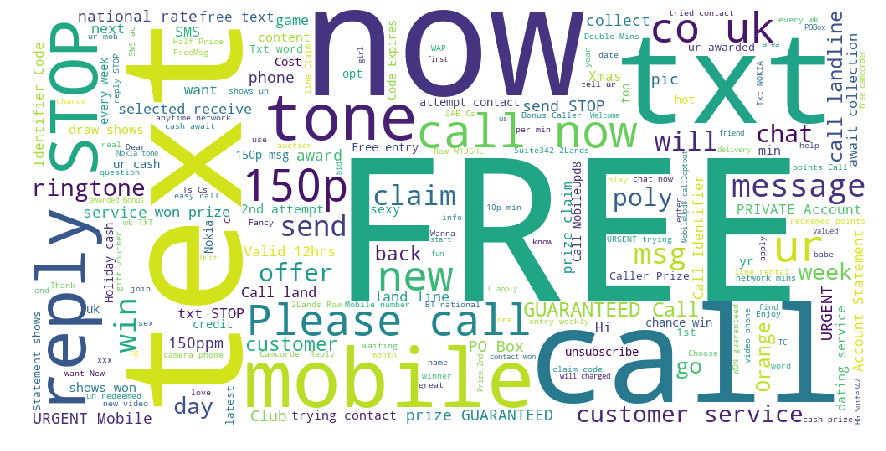

In [127]:
from wordcloud import WordCloud

wordcloud = WordCloud(width=1000, height=500, background_color="white").generate(' '.join(spam['text']))

plt.figure(figsize=(15,8))
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

From this, we can see that the most frequently used word is "free". This makes sense as it's usually used as a lure in order to get people to do something. Which also explains the fact that the other words that show up are those that elicit some type of action such as "call" or "text".

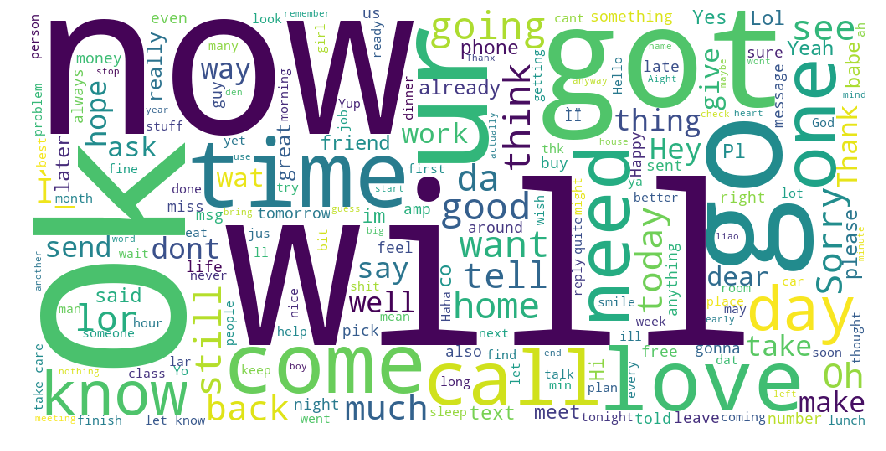

In [128]:
wordcloud = WordCloud(width=1000, height=500, background_color="white").generate(' '.join(ham['text']))

plt.figure(figsize=(15,8))
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

On the other hand, with ham messages, the most frequently used words are those that are typically used in a reply such as "ok" or having to do with one's feelings such as "love".